# Predicting Item Consumption with XGBoost

## Project Introduction

This project aims to predict the monthly consumption of various items using historical consumption data from the past three years. The predictions will help in inventory management and demand forecasting. We will use XGBoost, a powerful machine learning algorithm, to build our predictive models.


In [44]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Load and prepare data
data = pd.read_csv('data.csv')


## Data Preparation

We start by reshaping the data to have a proper format for our analysis. We melt the data frame to have monthly consumption in a single column, then extract and correct the year and month columns.


In [45]:
# Reshape data
monthly_data = pd.melt(data, id_vars=['ITEM DESCRIPTION'],
                       value_vars=[col for col in data.columns if 'JANUARY' in col or 'FEBRUARY' in col or 'MARCH' in col or 'APRIL' in col or 'MAY' in col or 'JUNE' in col or 'JULY' in col or 'AUGUST' in col or 'SEPTEMBER' in col or 'OCTOBER' in col or 'NOVEMBER' in col or 'DECEMBER' in col],
                       var_name='Month_Year', value_name='Consumption')

# Extract year and month
monthly_data['Year'] = monthly_data['Month_Year'].str.split('_').str[0]
monthly_data['Month'] = monthly_data['Month_Year'].str.split('_').str[1]

# Correct the reversed columns
monthly_data['Year'], monthly_data['Month'] = monthly_data['Month'], monthly_data['Year']

# Create a date column
monthly_data['Date'] = pd.to_datetime(monthly_data['Month'] + ' ' + monthly_data['Year'], format='%B %Y')

# Drop unnecessary columns
monthly_data = monthly_data.drop(columns=['Month_Year'])

# Sort by date
monthly_data = monthly_data.sort_values(by='Date')

# Set Date as index
monthly_data.set_index('Date', inplace=True)
monthly_data.head()


,ITEM DESCRIPTION,Consumption,Year,Month
Date,,,,
2019-01-01,18 - Reactive Protein (CRP) - 300t - Dt Slides...,4,2019,JANUARY
2019-01-01,Ringer Lactate - Compound Sodium Lactate Injec...,119,2019,JANUARY
2019-01-01,Ring File 79,33,2019,JANUARY
2019-01-01,Ribbon Gauze Non-Sterile (VAGINAL Pack) 5m x 5...,6,2019,JANUARY
2019-01-01,Ribbon Gauze Non-Sterile (ENT Pack) 5m x 1.25c...,0,2019,JANUARY


In [46]:
# Infer better data types (e.g., convert object types to appropriate types)
monthly_data = monthly_data.infer_objects(copy=False)

# Check for missing values
print(monthly_data.isnull().sum())

# Interpolate missing values
monthly_data = monthly_data.interpolate(method='time')

# Double-check for remaining missing values
print(monthly_data.isnull().sum())

ITEM DESCRIPTION    0
Consumption         0
Year                0
Month               0
dtype: int64
ITEM DESCRIPTION    0
Consumption         0
Year                0
Month               0
dtype: int64


C:\Users\USER\AppData\Local\Temp\ipykernel_13652\1113917010.py:8: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  monthly_data = monthly_data.interpolate(method='time')


In [47]:
# Calculate mean and standard deviation
mean = monthly_data['Consumption'].mean()
std = monthly_data['Consumption'].std()

# Identify outliers
outliers = monthly_data[np.abs(monthly_data['Consumption'] - mean) > 3 * std]

# Review outliers and determine if they should be adjusted or retained
retained_outliers = monthly_data[np.abs(monthly_data['Consumption'] - mean) <= 3 * std]

In [48]:
# Prepare for each item
items = monthly_data['ITEM DESCRIPTION'].unique()

future_predictions_all_items = []

## Model Training and Evaluation

We use XGBoost to train our model. The data is split into training and test sets to evaluate the model's performance. The mean squared error (MSE) is used as the evaluation metric.


In [49]:
for item in items:
    # Filter data for the current item
    item_data = monthly_data[monthly_data['ITEM DESCRIPTION'] == item].copy()

    # Prepare features and target
    item_data['Month'] = item_data.index.month
    item_data['Year'] = item_data.index.year
    item_data['Day_of_Week'] = item_data.index.dayofweek

    # Feature engineering
    item_data['Rolling_Avg_3'] = item_data['Consumption'].rolling(window=3).mean()  # 3-month rolling average
    item_data['Moving_Median_3'] = item_data['Consumption'].rolling(window=3).median()  # 3-month moving median
    item_data['Lag_1'] = item_data['Consumption'].shift(1)  # Previous month's consumption
    item_data['Lag_2'] = item_data['Consumption'].shift(2)  # Two months ago consumption
    item_data['Seasonal_Indicator'] = item_data['Month'].isin([12, 1, 2]).astype(int)  # Example for winter season

    # Drop rows with NaN values after feature engineering
    item_data = item_data.dropna()

    # Example target variable: Predict next month's consumption
    item_data['Next_Consumption'] = item_data['Consumption'].shift(-1)
    item_data = item_data.dropna()

    # Features and target
    X = item_data[['Month', 'Year', 'Day_of_Week', 'Rolling_Avg_3', 'Moving_Median_3', 'Lag_1', 'Lag_2', 'Seasonal_Indicator']]
    y = item_data['Next_Consumption']

    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Initialize XGBoost regressor
    model = xgb.XGBRegressor(objective='reg:squarederror')

    # Train the model
    model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f'Item: {item} - Mean Squared Error: {mse}')

    # Predict next month's consumption for the next 12 months
    future_dates = pd.date_range(start=item_data.index.max() + pd.DateOffset(months=1), periods=12, freq='ME')
    future_features = pd.DataFrame({
        'Month': future_dates.month,
        'Year': future_dates.year,
        'Day_of_Week': future_dates.dayofweek,
        'Rolling_Avg_3': [item_data['Consumption'].iloc[-3:].mean()] * 12,  # Use last 3 months for rolling avg
        'Moving_Median_3': [item_data['Consumption'].iloc[-3:].median()] * 12,  # Last 3 months for moving median
        'Lag_1': [item_data['Consumption'].iloc[-1]] * 12,  # Use last month for lag
        'Lag_2': [item_data['Consumption'].iloc[-2]] * 12,  # Use two months ago for lag
        'Seasonal_Indicator': future_dates.month.isin([12, 1, 2]).astype(int)  # Apply seasonal indicator to future dates
    })

    # Predict future consumption
    future_predictions = model.predict(future_features)

    # Create DataFrame for future predictions
    future_df = pd.DataFrame({'Date': future_dates, 'Item': item, 'Predicted_Consumption': future_predictions})
    future_predictions_all_items.append(future_df)

# Combine all future predictions into a single DataFrame
final_predictions = pd.concat(future_predictions_all_items)


Item: 18 - Reactive Protein (CRP) - 300t - Dt Slides - Vitros 250 79 - Mean Squared Error: 9.282118827200387
Item: Ringer Lactate - Compound Sodium Lactate Injection Ip - 500ml 79 - Mean Squared Error: 237.18135913159253
Item: Ring File 79 - Mean Squared Error: 1.81081846441329
Item: Ribbon Gauze Non-Sterile (VAGINAL Pack) 5m x 5cm 79 - Mean Squared Error: 1.0893758164363703
Item: Ribbon Gauze Non-Sterile (ENT Pack) 5m x 1.25cm 79 - Mean Squared Error: 3.7351121542749772
Item: Ribbon - Barcode Label Printer Ribbon Zebra Tlc Label Roll+Wax 79 - Mean Squared Error: 33.44524978419124
Item: RF Reagent Pack 79 - Mean Squared Error: 5.46052801845589
Item: Reservoir Bag - Infant 79 - Mean Squared Error: 0.9705842234052836
Item: Reservoir Bag - Child 79 - Mean Squared Error: 3.9069697982695573
Item: Reservoir Bag - Adult 79 - Mean Squared Error: 1.8916977026686705
Item: Referral Form (H-1) - A4 79 - Mean Squared Error: 1.1584302843755847
Item: Recordable Cd With Cover 79 - Mean Squared Error: 

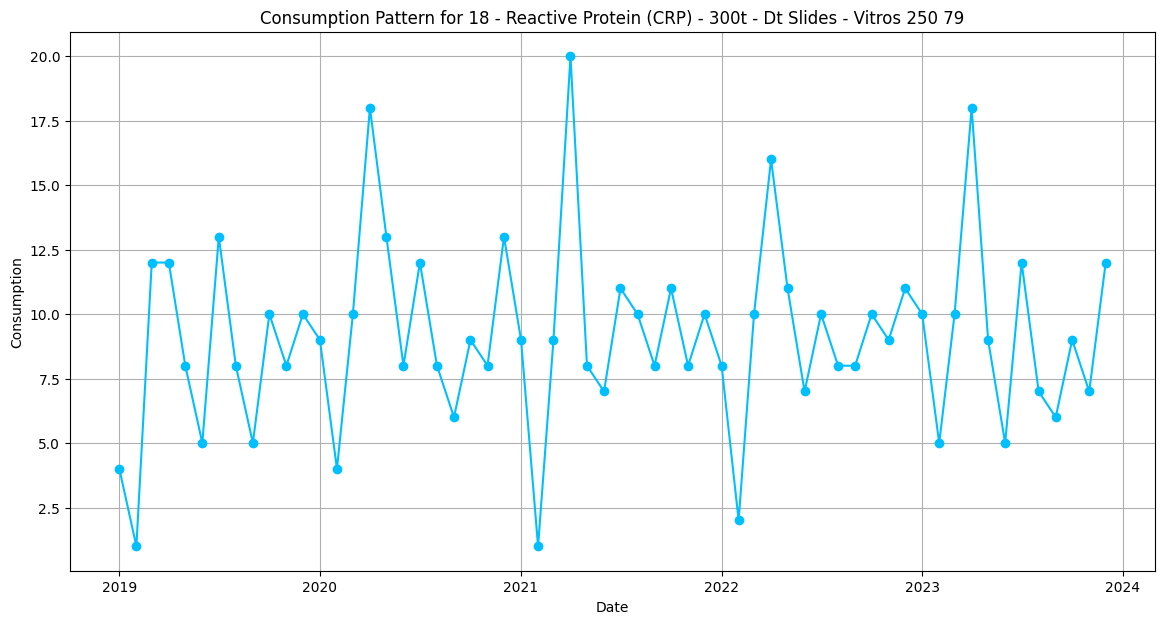

In [50]:
# Plot consumption patterns for a sample item
sample_item = monthly_data['ITEM DESCRIPTION'].unique()[0]
sample_data = monthly_data[monthly_data['ITEM DESCRIPTION'] == sample_item]

plt.figure(figsize=(14, 7))
plt.plot(sample_data.index, sample_data['Consumption'], marker='o', linestyle='-', color='deepskyblue' )
plt.title(f'Consumption Pattern for {sample_item}')
plt.xlabel('Date')
plt.ylabel('Consumption')
plt.grid(True)
plt.show()


In [51]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample item for plotting
sample_item = monthly_data['ITEM DESCRIPTION'].unique()[0]
sample_data = monthly_data[monthly_data['ITEM DESCRIPTION'] == sample_item].copy()  # Use .copy() to avoid SettingWithCopyWarning

# Feature Engineering
sample_data['Rolling_Avg_3'] = sample_data['Consumption'].rolling(window=3).mean()
sample_data['Moving_Median_3'] = sample_data['Consumption'].rolling(window=3).median()
sample_data['Lag_1'] = sample_data['Consumption'].shift(1)
sample_data['Lag_2'] = sample_data['Consumption'].shift(2)

# Drop NaN values
sample_data.dropna(inplace=True)



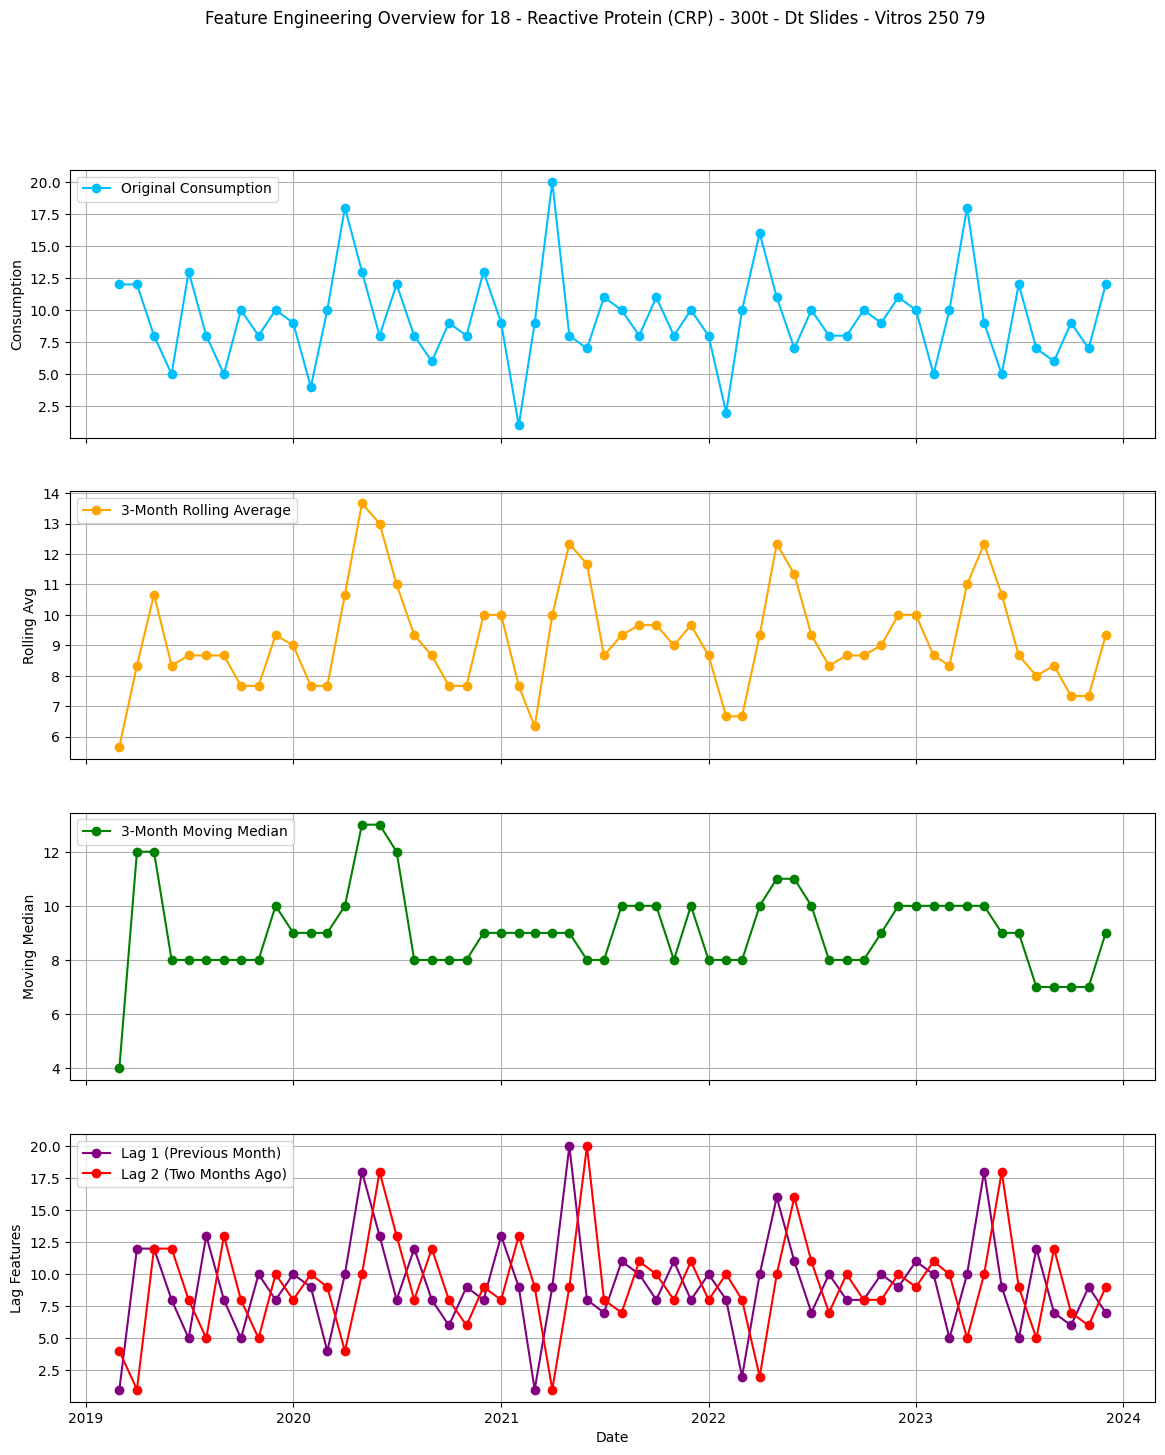

In [52]:
fig, axs = plt.subplots(4, 1, figsize=(14, 16), sharex=True)

# Original Consumption
axs[0].plot(sample_data.index, sample_data['Consumption'], marker='o', linestyle='-', color='deepskyblue', label='Original Consumption')
axs[0].set_ylabel('Consumption')
axs[0].legend(loc='upper left')
axs[0].grid(True)

# Rolling Average
axs[1].plot(sample_data.index, sample_data['Rolling_Avg_3'], marker='o', linestyle='-', color='orange', label='3-Month Rolling Average')
axs[1].set_ylabel('Rolling Avg')
axs[1].legend(loc='upper left')
axs[1].grid(True)

# Moving Median
axs[2].plot(sample_data.index, sample_data['Moving_Median_3'], marker='o', linestyle='-', color='green', label='3-Month Moving Median')
axs[2].set_ylabel('Moving Median')
axs[2].legend(loc='upper left')
axs[2].grid(True)

# Lag Features
axs[3].plot(sample_data.index, sample_data['Lag_1'], marker='o', linestyle='-', color='purple', label='Lag 1 (Previous Month)')
axs[3].plot(sample_data.index, sample_data['Lag_2'], marker='o', linestyle='-', color='red', label='Lag 2 (Two Months Ago)')
axs[3].set_xlabel('Date')
axs[3].set_ylabel('Lag Features')
axs[3].legend(loc='upper left')
axs[3].grid(True)

plt.suptitle(f'Feature Engineering Overview for {sample_item}')
plt.show()


## Save predictions to CSV

In [53]:
# Save predictions to CSV
final_predictions.to_csv('xgboost_predictions.csv', index=False)
print("Predictions saved to 'xgboost_predictions.csv'")

# Display the first few rows of the predictions
final_predictions.head()

Predictions saved to 'xgboost_predictions.csv'


,Date,Item,Predicted_Consumption
0,2023-12-31,18 - Reactive Protein (CRP) - 300t - Dt Slides...,9.766091
1,2024-01-31,18 - Reactive Protein (CRP) - 300t - Dt Slides...,2.163377
2,2024-02-29,18 - Reactive Protein (CRP) - 300t - Dt Slides...,10.033125
3,2024-03-31,18 - Reactive Protein (CRP) - 300t - Dt Slides...,11.019633
4,2024-04-30,18 - Reactive Protein (CRP) - 300t - Dt Slides...,10.558026


## Detailed Comparison and Visualization
In this section, we will compare the historical consumption and the predicted consumption for a specific item (e.g., the first item in the dataset). This will help us understand how well the model performs and visualize the consumption trends.

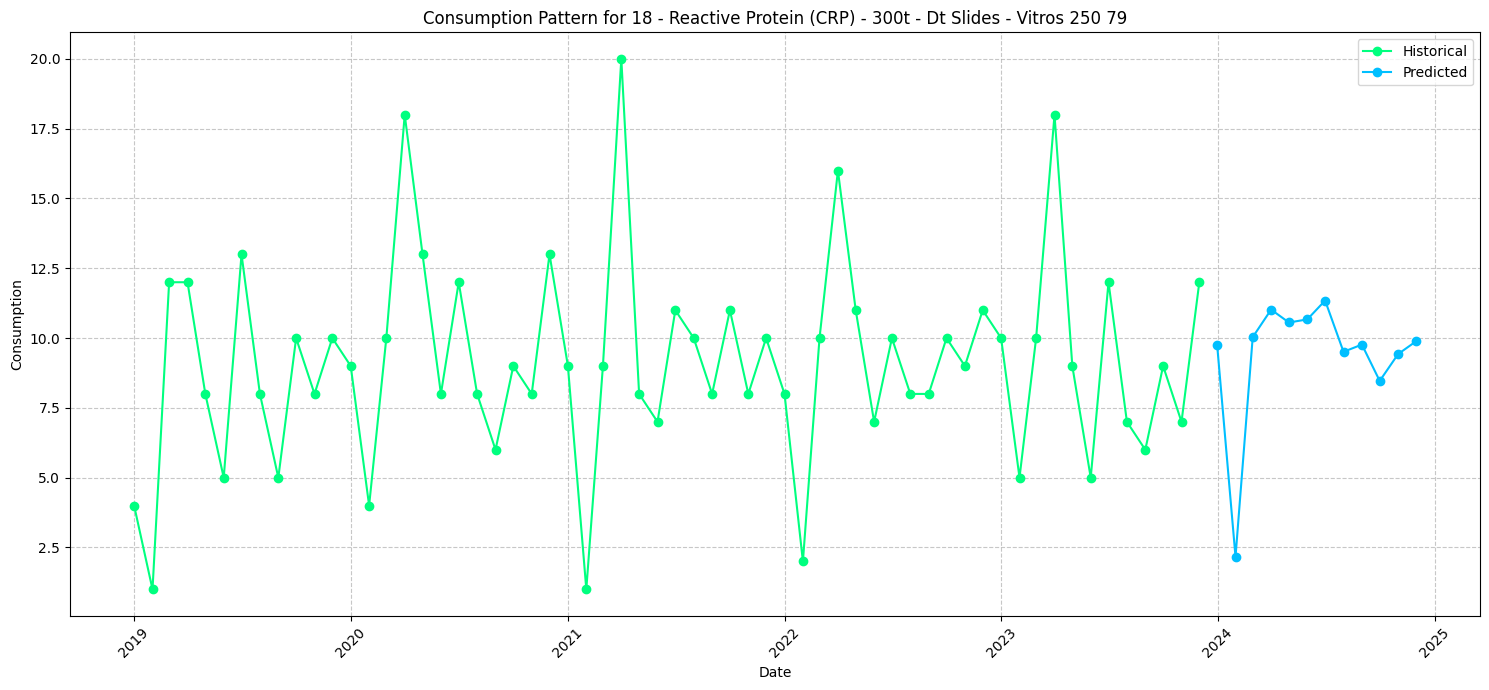

Plotting consumption for: 18 - Reactive Protein (CRP) - 300t - Dt Slides - Vitros 250 79
Historical data range: 2019-01-01 00:00:00 to 2023-12-01 00:00:00
Prediction range: 2023-12-31 00:00:00 to 2024-11-30 00:00:00


In [54]:
# Choose an item to plot (you can change this to any item in your dataset)
item_to_plot = items[0]

# Filter data for the chosen item
historical_data = monthly_data[monthly_data['ITEM DESCRIPTION'] == item_to_plot]
predicted_data = final_predictions[final_predictions['Item'] == item_to_plot]

# Create the plot
plt.figure(figsize=(15, 7))

# Plot historical data
plt.plot(historical_data.index, historical_data['Consumption'], label='Historical', color='springgreen', marker='o')

# Plot predicted data
plt.plot(predicted_data['Date'], predicted_data['Predicted_Consumption'], label='Predicted', color='deepskyblue', marker='o')

# Add labels and title
plt.title(f'Consumption Pattern for {item_to_plot}')
plt.xlabel('Date')
plt.ylabel('Consumption')

# Add legend
plt.legend()

# Show grid
plt.grid(True, linestyle='--', alpha=0.7)


# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Show the plot
plt.show()

# Print some information about the plot
print(f"Plotting consumption for: {item_to_plot}")
print(f"Historical data range: {historical_data.index.min()} to {historical_data.index.max()}")
print(f"Prediction range: {predicted_data['Date'].min()} to {predicted_data['Date'].max()}")